## Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 808kB 2.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=c2790dc1041f75bd7d1ce864eae1bbf1063b4bcea2ab3e274f35e332541164af
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


## Loading the data

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [0]:
df_comp = raw_data.copy()

In [0]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [0]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [0]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [0]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [0]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [0]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [10]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [0]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-16"
end_date = "2015-01-01"

In [0]:
df_pred = results_ar.predict(start = start_date, end = end_date)

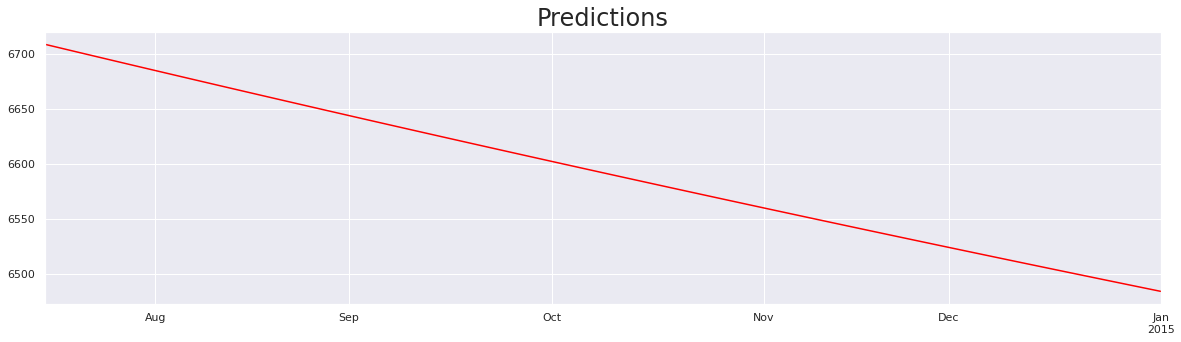

In [14]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions", size = 24)
plt.show()

In [0]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

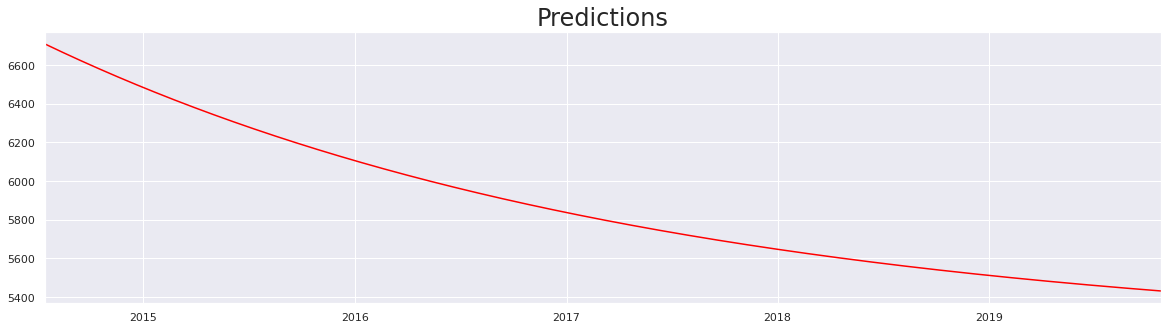

In [16]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions", size = 24)
plt.show()

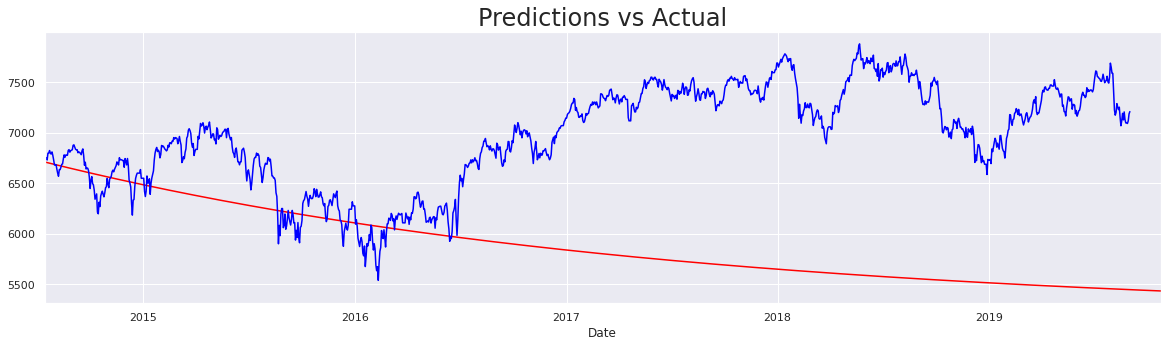

In [17]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

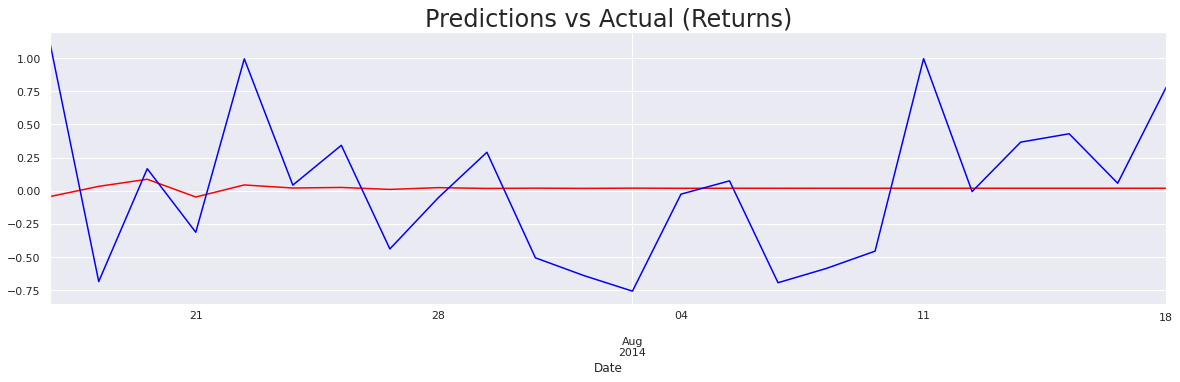

In [39]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [40]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(5, 0)   Log Likelihood               -8307.926
Method:                       css-mle   S.D. of innovations              1.143
Date:                Sat, 25 Apr 2020   AIC                          16629.851
Time:                        07:24:28   BIC                          16675.947
Sample:                    01-11-1994   HQIC                         16645.952
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.435      0.151      -0.007       0.045
ar.L1.ret_ftse    -0.0222      0.014     -1.630      0.103      -0.049       0.005
ar.L2.ret_ftse    -0.0531      0.014     -3.891      0.000      -0.080      -0.026
ar.L3.ret_ftse    -0.0807      0.014     -5.925      0.000      -0.107      -0.054
ar.L4.ret_ftse     0.0422      0.014      3.095      0.002       0.015       0.069
ar.L5.ret_ftse    -0.0561      0.014     -4.114      0.000      -0.083      -0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5671           -0.0000j            1.5671           -0.5000
AR.2           -0.2911           -1.7478j            1.7719           -0.2763
AR.3           -0.2911           +1.7478j            1.7719            0.2763
AR.4            1.4506           -1.2313j            1.9027           -0.1120
AR.5            1.4506           +1.2313j            1.9027            0.1120
-----------------------------------------------------------------------------
"""

### MA

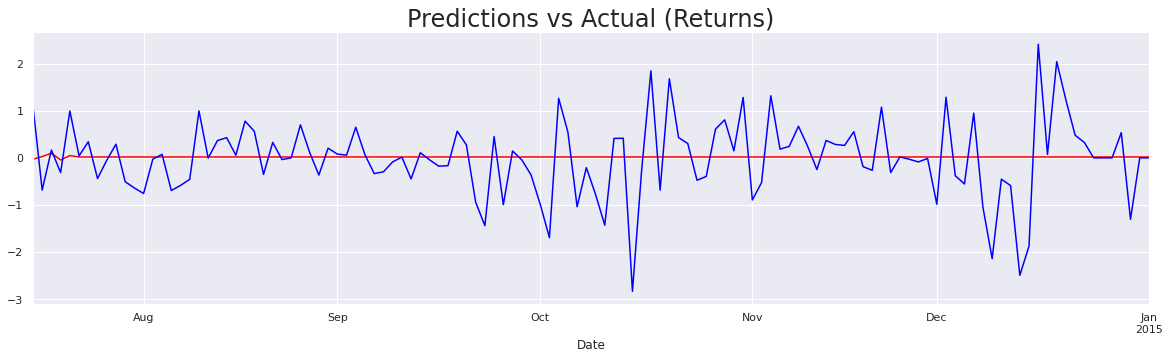

In [22]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,5))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [21]:
results_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(0, 1)   Log Likelihood               -8344.556
Method:                       css-mle   S.D. of innovations              1.151
Date:                Sat, 25 Apr 2020   AIC                          16695.111
Time:                        06:20:04   BIC                          16714.866
Sample:                    01-11-1994   HQIC                         16702.011
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.015      1.248      0.212      -0.011       0.049
ma.L1.ret_ftse    -0.0258      0.014     -1.782      0.075      -0.054       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.7777           +0.0000j           38.7777            0.0000
-----------------------------------------------------------------------------
"""

In [0]:
df_pred_ma.head()

### ARMA

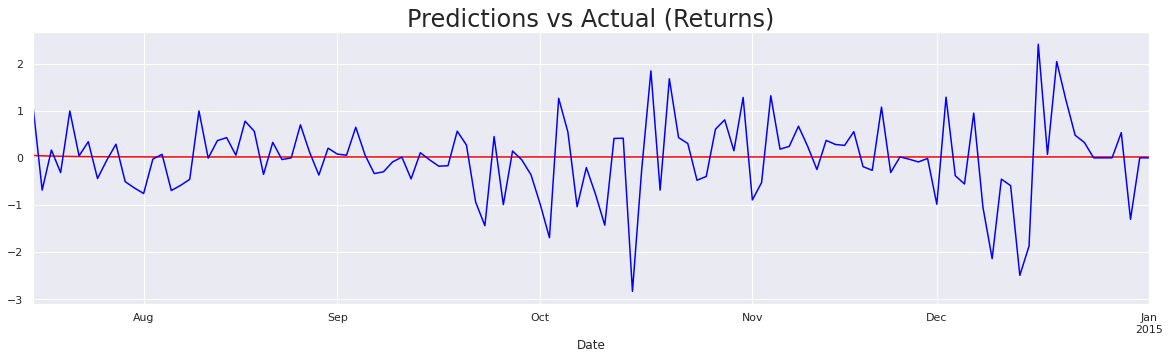

In [23]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [24]:
df_pred_arma.head()

2014-07-16    0.051210
2014-07-17    0.043852
2014-07-18    0.038185
2014-07-21    0.033818
2014-07-22    0.030455
Freq: B, dtype: float64

In [25]:
df_pred_arma.tail()

2014-12-26    0.019172
2014-12-29    0.019172
2014-12-30    0.019172
2014-12-31    0.019172
2015-01-01    0.019172
Freq: B, dtype: float64

### ARMAX

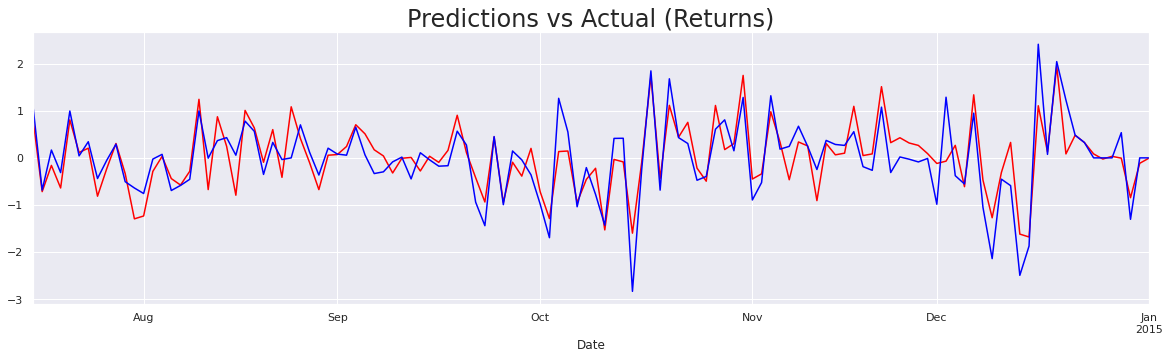

In [26]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

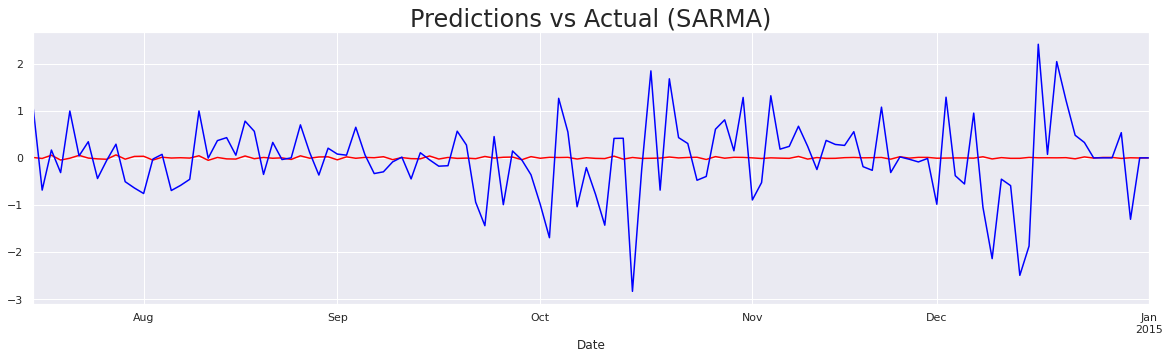

In [27]:
end_date = "2015-01-01"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

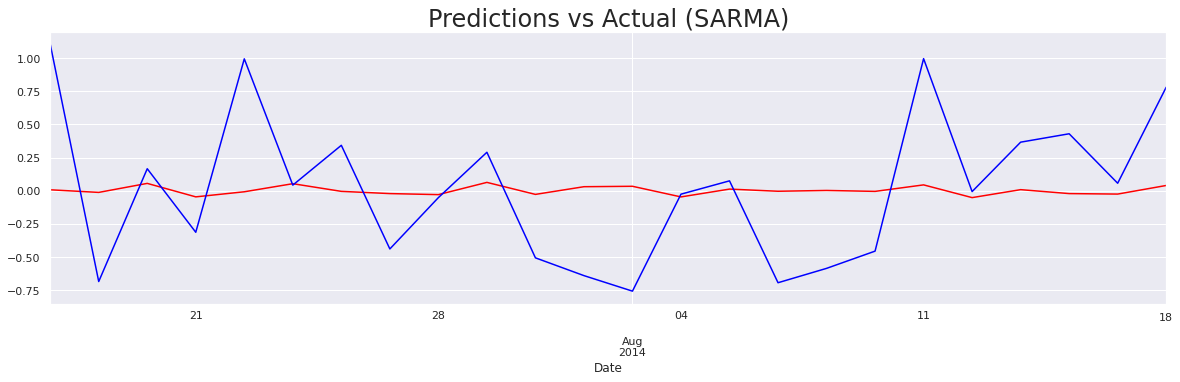

In [30]:
end_date = "2014-08-18"

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

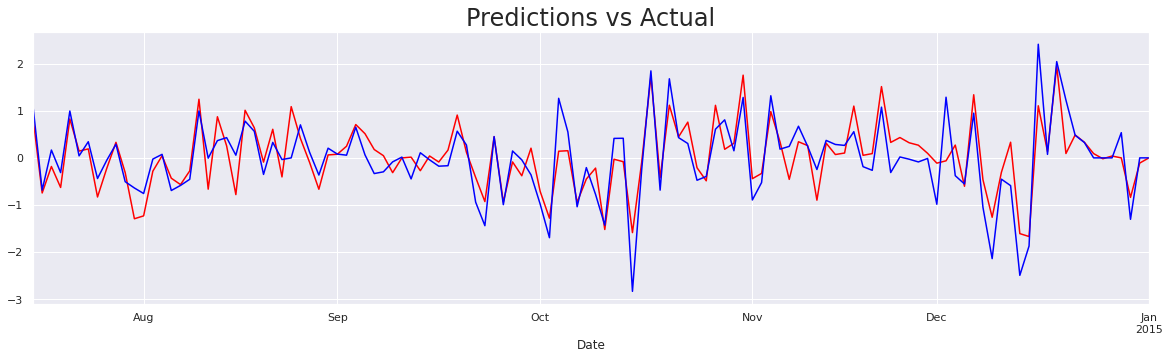

In [31]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [0]:
model_auto0 = auto_arima(df.ret_ftse[1:])

In [0]:
df_auto_pred0 = pd.DataFrame(model_auto0.predict(n_periods = len(df_test[start_date:end_date])), index = df_test[start_date:end_date].index)

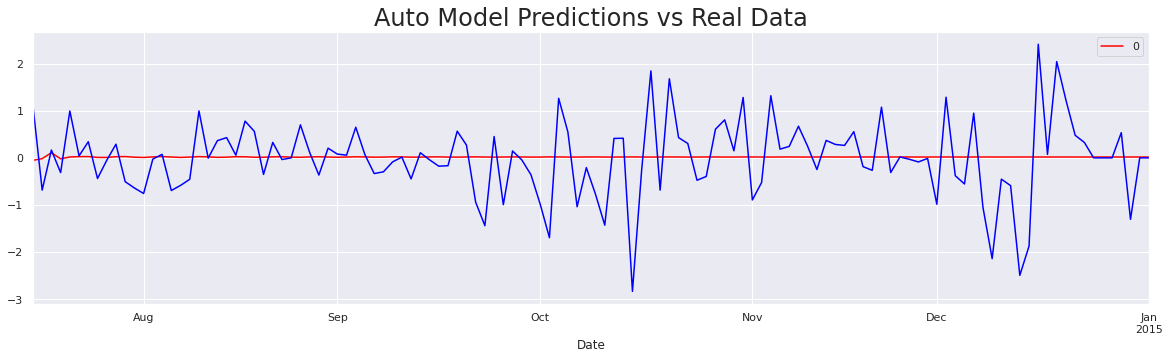

In [34]:
df_auto_pred0.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [0]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [0]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

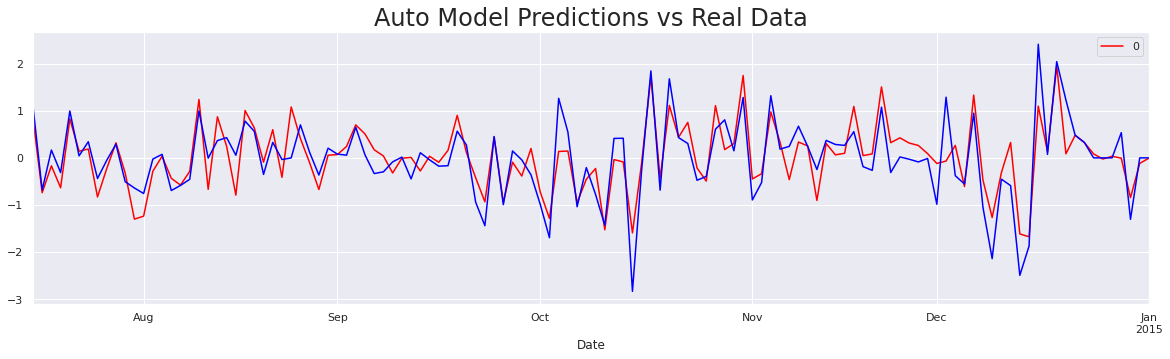

In [37]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

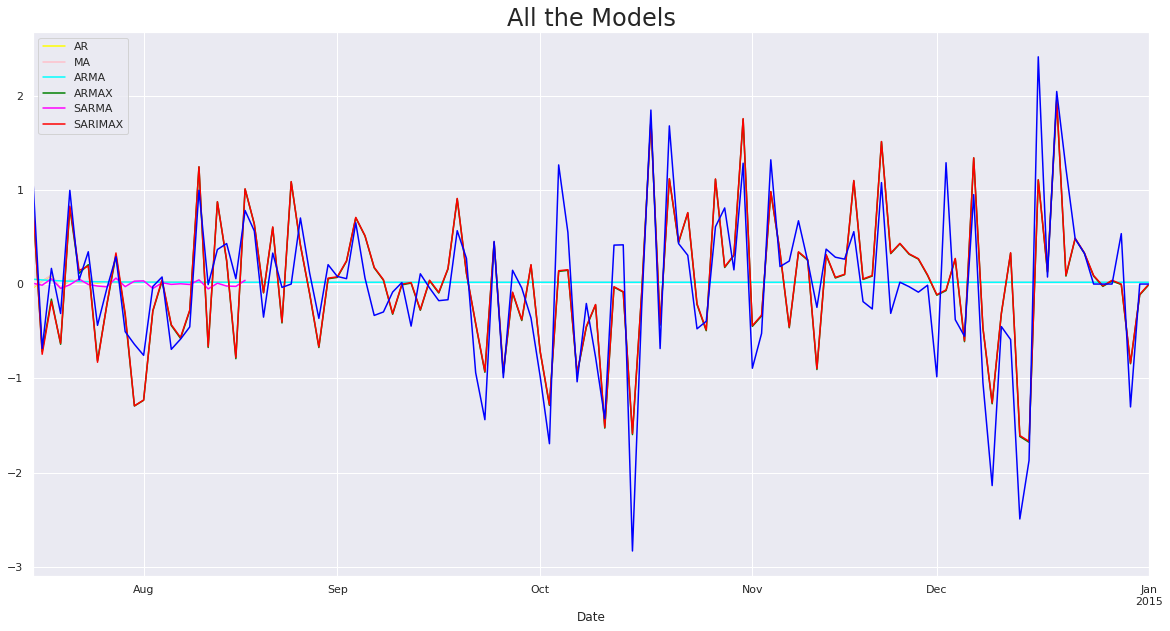

In [41]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [42]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7311.064967249472
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7311.064229906422
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [0]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

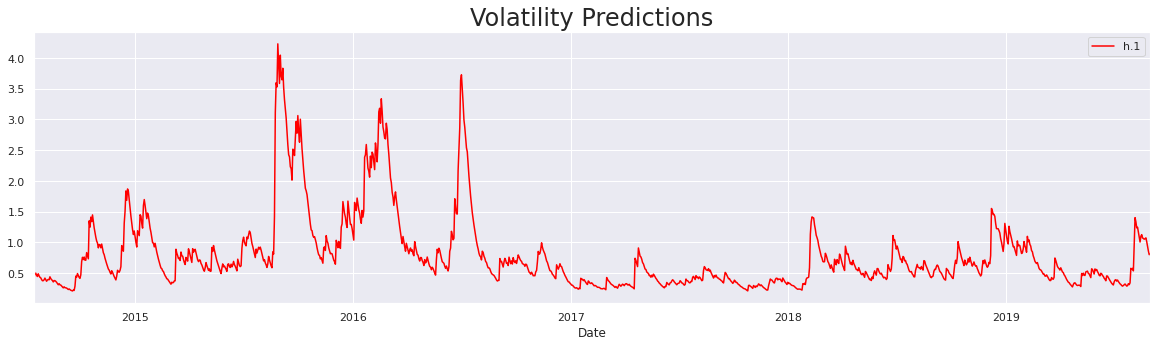

In [44]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Volatility Predictions", size = 24)
plt.show()

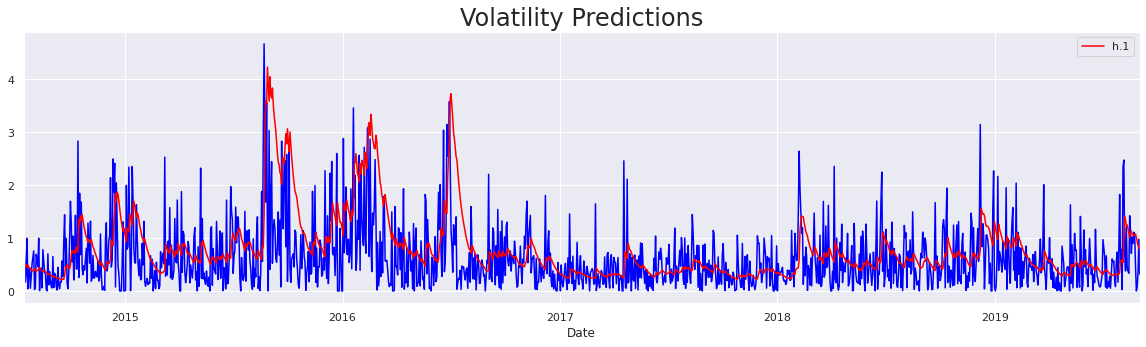

In [45]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [46]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


### Multivariate Regression Model

In [0]:
from statsmodels.tsa.api import VAR

In [0]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [0]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [55]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Apr, 2020
Time:                     07:48:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

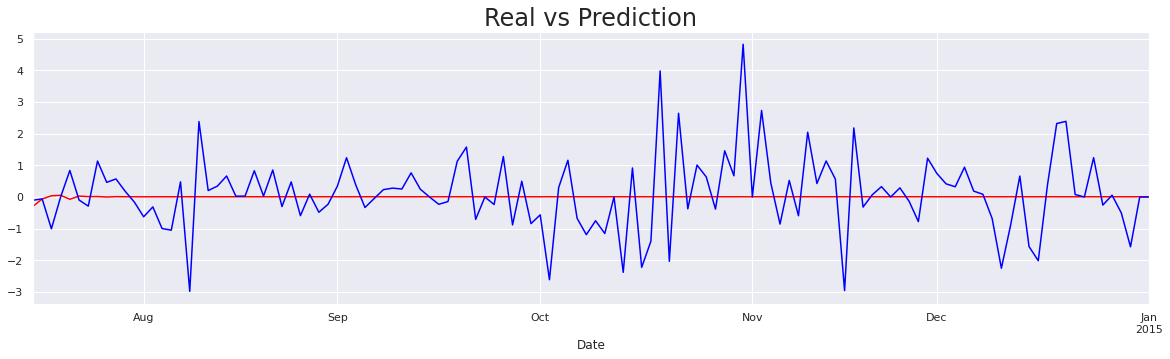

In [56]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

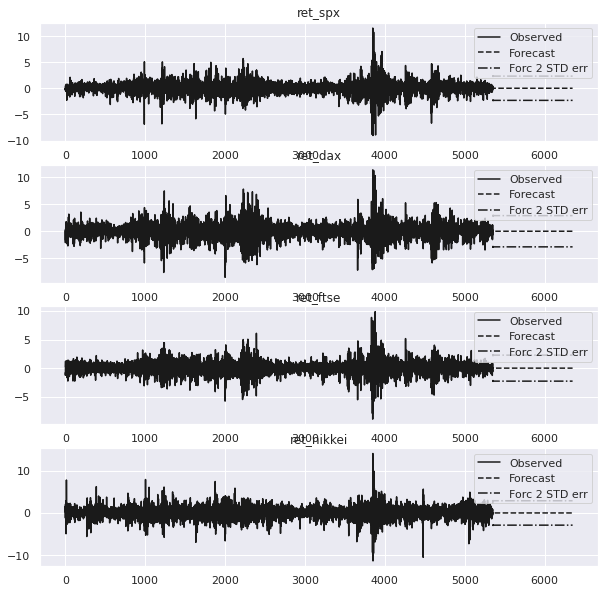

In [57]:
results_var_ret.plot_forecast(1000)
plt.show()